## Read in, libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import pandas_profiling
%matplotlib inline
sleepdata=pd.read_csv("health/sleep-export2.csv")
stepcount=pd.read_csv("health/step_count.csv")
exercise=pd.read_csv("health/exercise.csv")
heartrate=pd.read_csv("health/heart_rate.csv")
floors=pd.read_csv("health/floors_climbed.csv")

## Drop cols, col_col names, type, offset

In [2]:
#drop unnecessary columns
sleepdata=sleepdata.drop(['com.samsung.health.sleep.update_time','com.samsung.health.sleep.datauuid', 
                          'com.samsung.health.sleep.custom'], axis=1)
floors=floors.drop(['update_time','pkg_name', 'datauuid'], axis=1)
heartrate=heartrate.drop(['update_time','binning_data', 'pkg_name', 'datauuid'], axis=1)
stepcount=stepcount.drop(['update_time','pkg_name','datauuid'], axis=1) #meters, kilocalories, m/s
exercise=exercise.drop(['live_data', 'datauuid', 'deviceuuid', 'pkg_name', 'update_time','exercise_custom_type', 'max_rpm', 
  'max_rpm', 'mean_caloricburn_rate', 'mean_power', 'max_power', 'mean_rpm',
  'max_caloricburn_rate', 'custom','comment','additional'], axis=1)

In [3]:
#rename columns for convienience
sleepdata.columns=['Unnamed:0','efficiency','has_sleep_data', 'quality', 'end_time',
                   'original_wake_up_time','start_time','time_offset',
                   'original_bed_time','create_time', 'original_efficiency']

#change type of columns where necessary
exercise['duration']=exercise['duration']/(1000*60*60)
sleepdata['duration']=(sleepdata['end_time']-sleepdata['start_time'])/3600000
sleepdata['start_time']=pd.to_datetime(sleepdata['start_time'], unit='ms')
sleepdata['end_time']=pd.to_datetime(sleepdata['end_time'], unit='ms')
sleepdata['create_time']=pd.to_datetime(sleepdata['create_time'], unit='ms')

#apply offset to all datetime columns
def offset(dataframe,columnname_offset,columnname_torewrite):
    column_offset=[]
    hr= lambda a : int(a[3:6])
    mins= lambda a : int(a[3]+a[6:8])
    for i in dataframe.index:
        hour=(hr(dataframe[columnname_offset][i]))
        minute=(mins(dataframe[columnname_offset][i]))
        human_readable_time=pd.to_datetime(dataframe[columnname_torewrite][i])
        new_time=human_readable_time+datetime.timedelta(hours=hour, minutes=minute )
        column_offset.append(new_time)
    return column_offset

In [4]:
sleepdata['offset_starttime']=offset(sleepdata, 'time_offset', 'start_time')
sleepdata['offset_endtime']=offset(sleepdata, 'time_offset', 'end_time')
sleepdata['offset_createtime']=offset(sleepdata, 'time_offset', 'create_time')

exercise['offset_starttime']=offset(exercise, 'time_offset', 'start_time')
exercise['offset_endtime']=offset(exercise, 'time_offset', 'end_time')
exercise['offset_createtime']=offset(exercise, 'time_offset', 'create_time')

stepcount['offset_starttime']=offset(stepcount, 'time_offset', 'start_time')
stepcount['offset_endtime']=offset(stepcount, 'time_offset', 'end_time')
stepcount['offset_createtime']=offset(stepcount, 'time_offset', 'create_time')

heartrate['offset_starttime']=offset(heartrate, 'time_offset', 'start_time')
heartrate['offset_endtime']=offset(heartrate, 'time_offset', 'end_time')
heartrate['offset_createtime']=offset(heartrate, 'time_offset', 'create_time')

floors['offset_starttime']=offset(floors, 'time_offset', 'start_time')
floors['offset_endtime']=offset(floors, 'time_offset', 'end_time')
floors['offset_createtime']=offset(floors, 'time_offset', 'create_time')

## Index, sort

In [5]:
sleepdata=sleepdata.sort_values(by='offset_createtime')
stepcount=stepcount.sort_values(by='offset_starttime')
floors=floors.sort_values(by='offset_starttime')
heartrate=heartrate.sort_values(by='offset_starttime')
exercise=exercise.sort_values(by='offset_starttime')
    
sleepdata=sleepdata.set_index('offset_createtime')
stepcount=stepcount.set_index('offset_starttime')
floors=floors.set_index('offset_starttime')
heartrate=heartrate.set_index('offset_starttime')
exercise=exercise.set_index('offset_starttime')

## Stepcount

## Literature says that average walking pace is ~1.4m/s, while 1.7-1.8m/s is considered brisk walking pace. ~2.5m/s is considered average jogging pace for humans and an elephant runs at average speeds of 6m/s. Usain Bolt's average speed is ~10m/s. 

## Stepcount data is available between 2018-03-31 and 2018-05-03. Majority of stepcount data for this individual comes from walking. Jogging and running (speed >2.5m/s) also occurs on most days. The person goes on many runs, between 2018-03-31 and 2018-05-03.

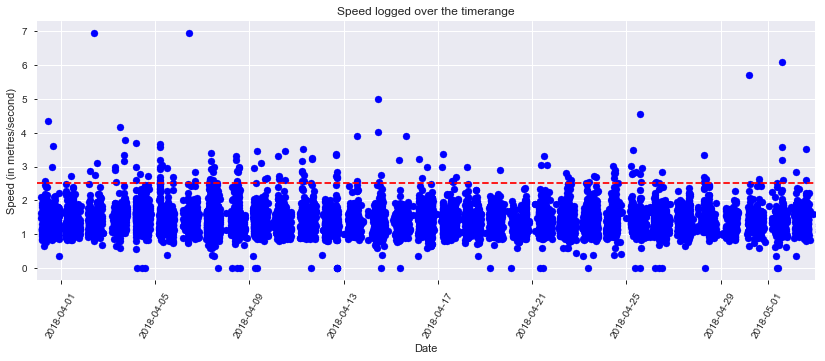

In [6]:
ax=plt.axes([0,0.05,1.8,0.9])
plt.scatter(stepcount.index,stepcount['speed'], color='blue')
plt.xlabel('Date')
plt.title('Speed logged over the timerange')
plt.ylabel('Speed (in metres/second)')
plt.xticks(rotation=60)
plt.xlim('2018-03-31','2018-05-03')
ax.axhline(y=2.5, linestyle='--', color='red')

## Zooming in on a randomly selected week, Monday to Sunday, the person logs high speeds on all days, especially in the early morning. 

## High speeds are logged around or after midday on some days too. 

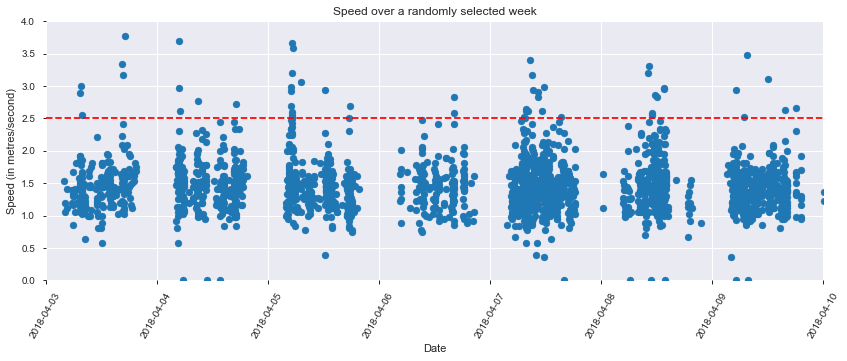

In [7]:
stepcount_sub=stepcount['2018-04-03':'2018-04-10']
ax=plt.axes([0,0.05,1.8,0.9])
plt.scatter(stepcount_sub.index,stepcount_sub['speed'] )
plt.xlabel('Date')
plt.title('Speed over a randomly selected week')
plt.ylabel('Speed (in metres/second)')
plt.xticks(rotation=60)
plt.xlim('2018-04-03','2018-04-10')
plt.ylim(0,4)
ax.axhline(y=2.5, linestyle='--', color='red')

## The high speeds may give us an indication of motivation for running. Motivation is high on Monday, Tueday and Wednesday. Thursday may be a rest day or low-motivation day. Motivation to run faster goes back up into the weekend. 

## The highest speed logged in the entire dataset is ~7m/s. Individual isn't Usain Bolt but runs comparable to that of a running elephant. His average running pace (when speed >2.5m/s) is 3.06m/s. 

In [8]:
print('In the entire dataset: ')
print('Mean pace for running (when speed >2.5) is %3.2f m/s. ' %stepcount[stepcount['speed']>2.5]['speed'].mean())
print('Maximum pace for running (when speed >2.5) is %3.2f m/s.' %stepcount[stepcount['speed']>2.5]['speed'].max())

In the entire dataset: 
Mean pace for running (when speed >2.5) is 3.06 m/s. 
Maximum pace for running (when speed >2.5) is 6.94 m/s.


## The distace data for this same randomly selected week shows that >3-6km are logged on most days, in this time range. The individual may be training for a 5km or 10km marathon. 

## discrete speed values are associated with ~1minute time durations and short distance values (mean ~40m). So RESAMPLING distance over various timeperiods allows us to better study trends in this data.

In [9]:
step_sub_2h=stepcount_sub.resample('2h').sum()

(736787.0, 736794.0)

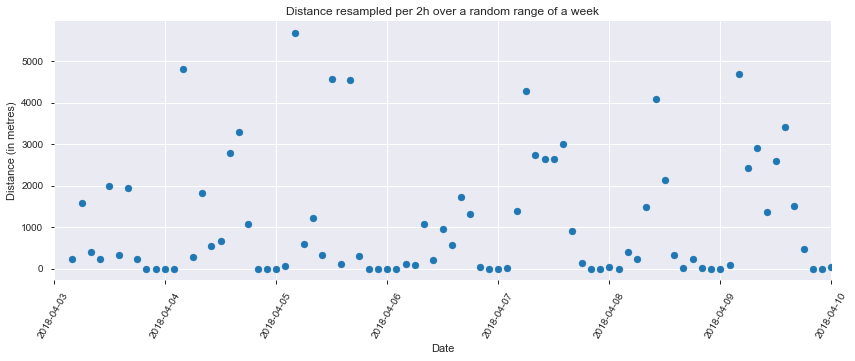

In [10]:
ax=plt.axes([0,0.05,1.8,0.9])
plt.scatter(step_sub_2h.index,step_sub_2h['distance'] )
plt.xlabel('Date')
plt.title('Distance resampled per 2h over a random range of a week')
plt.ylabel('Distance (in metres)')
plt.xticks(rotation=60)
plt.xlim('2018-04-03','2018-04-10')

## We can extend our analysis to the rest of the dataset. We find that the individual travels ~10km on 27th April 2018 and travels around 6km several times too. Values so high cannot be an artifact from resampling several short walks. 

                     Unnamed: 0  count     calorie       speed  distance
offset_starttime                                                        
2018-04-27 04:00:00      689523  13802  559.459998  186.563041  9934.681


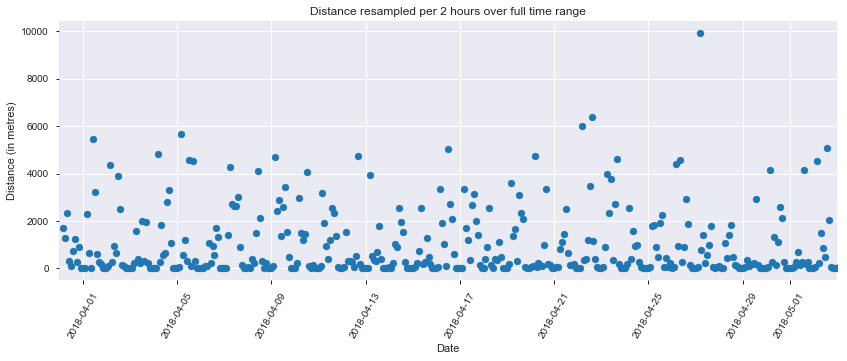

In [11]:
step_2h=stepcount.resample('2h').sum()
ax=plt.axes([0,0.05,1.8,0.9])
plt.scatter(step_2h.index,step_2h['distance'] )
plt.xlabel('Date')
plt.title('Distance resampled per 2 hours over full time range')
plt.ylabel('Distance (in metres)')
plt.xticks(rotation=60)
plt.xlim('2018-03-31','2018-05-03')
print(step_2h[step_2h['distance']>8000])

## All runs (speed>2.5m/s) have been saved in a new dataframe. 

In [12]:
speed=stepcount[stepcount['speed']>2.5]

## Individual runs most often at 5am, 7am or 3pm. The largest distances covered and calories burnt  are also around this time (5am and 4pm).  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

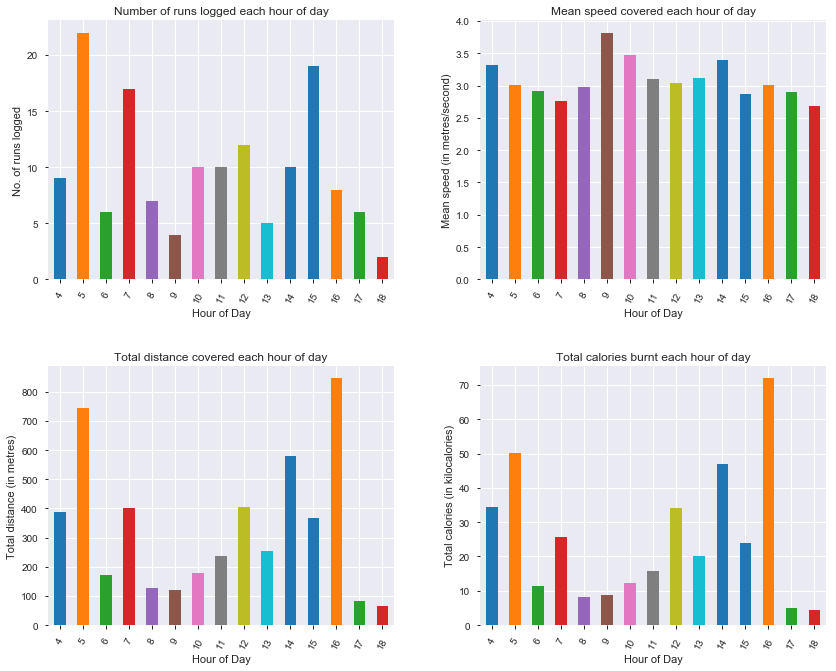

In [13]:
#label=['Monday','Tuesday', 'Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
plt.axes([0,1.2,0.8,0.9])
speed.groupby(speed.index.hour).count()['Unnamed: 0'].plot(kind='bar')
plt.title('Number of runs logged each hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('No. of runs logged')
plt.xticks(rotation=60)
plt.axes([1,0,0.8,0.9])
speed.groupby(speed.index.hour).sum()['calorie'].plot(kind='bar')
plt.title('Total calories burnt each hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Total calories (in kilocalories)')
plt.xticks(rotation=60)
plt.axes([1,1.2,0.8,0.9])
speed.groupby(speed.index.hour).mean()['speed'].plot(kind='bar')
plt.title('Mean speed covered each hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean speed (in metres/second)')
plt.xticks(rotation=60)
plt.axes([0,0,0.8,0.9])
speed.groupby(speed.index.hour).sum()['distance'].plot(kind='bar')
plt.title('Total distance covered each hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Total distance (in metres)')
plt.xticks(rotation=60)

## Heartrate

## Heartrate and stepcount data were compared. Too few heart rate data points were available in the required timerange to make good conclusions. 

Hearrate of 
65.0bpm on 2018-04-08, 
71.0bpm on 2018-04-11,
149.0bpm on 2018-04-19 and 
76.0bpm on 2018-04-25 
can be attributed to walking or runs taken while the individual trained for a 5km or 10km marathon. 
      


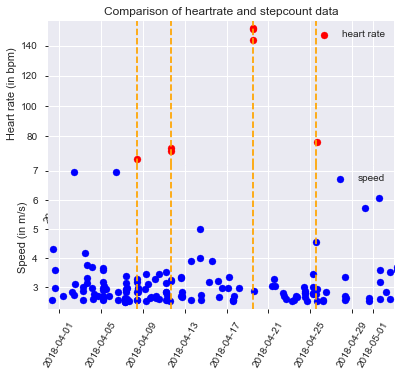

In [14]:
marathon_rate=heartrate['2018-03-31':'2018-05-03']
series1=marathon_rate.groupby(marathon_rate.index.date).mean()['heart_rate']
series2=marathon_rate.index.date
plt.axes([0,.5,0.8,0.5])
plt.scatter(marathon_rate.index,marathon_rate['heart_rate'], label='heart rate', color='red')
plt.legend(loc='upper right')
plt.xticks(rotation=60)
plt.ylabel('Heart rate (in bpm)')
plt.title('Comparison of heartrate and stepcount data')
plt.xlim('2018-03-31','2018-05-03')
plt.axvline(x='2018-04-08 10:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-11 16:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-19 13:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-25 14:00:00', linestyle='--', color='orange')
plt.axes([0,0,0.8,0.5])
plt.scatter(speed.index,speed['speed'], label='speed', color='blue')
plt.legend(loc='upper right')
plt.xlim('2018-03-31','2018-05-03')
plt.xticks(rotation=60)
plt.ylabel('Speed (in m/s)')
plt.axvline(x='2018-04-08 10:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-11 16:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-19 13:00:00', linestyle='--', color='orange')
plt.axvline(x='2018-04-25 14:00:00', linestyle='--', color='orange')


print('''Hearrate of 
{0}bpm on {1}, 
{2}bpm on {3},
{4}bpm on {5} and 
{6}bpm on {7} 
can be attributed to walking or runs taken while the individual trained for a 5km or 10km marathon. 
      '''.format(series1[0],series2[0],series1[1],series2[2],series1[2],series2[5],series1[3],series2[6]))

## There may be problems with logging heart rate, rate may not be logged during all instances of activity. 

## A regular person has a resting heart rate of ~60bpm but this individual has a heart rate of 60-75 bpm on days that the person is running fast. A trained athlete may show such a low heart rate during vigorous activity, but given the lack of other kinds of exercise (shown below, from exercise data), it is unlikely this person is an athlete. So heart rate was likely not monitered during runs. Person does show a heart rate of 149bpm on 2018-04-19 which is closer to the expected value for the average individual running. 

## Literature says that women ages 40-49 have the highest average RHR of all users at 67.4 bpm, while men ages 40-49 have the highest average RHR among males at 64.6 bpm. Since this individual has a mean heart rate of 64.5 BPM this person may be a man between 40-49 years of age. 

Heart Rate from discrete data
Mean:  64.52733118971061 bpm
Maximum:  169.0 bpm
Minimum:  45.0 bpm


count    311.000000
mean      64.527331
std       18.870143
min       45.000000
25%       54.000000
50%       60.000000
75%       68.000000
max      169.000000
Name: heart_rate, dtype: float64

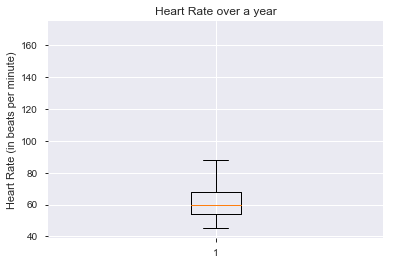

In [15]:
print('Heart Rate from discrete data')
print('Mean: ', heartrate['heart_rate'].mean(), 'bpm')
print('Maximum: ', heartrate['heart_rate'].max(), 'bpm')
print('Minimum: ', heartrate['heart_rate'].min(), 'bpm')
plt.boxplot(heartrate['heart_rate'])
plt.ylabel('Heart Rate (in beats per minute)')
plt.title('Heart Rate over a year')
heartrate['heart_rate'].describe()

In [16]:
#Heart rate data is available between 2016-06-09 to 2018-04-25 and a few points in 1969. 

Count of Heart rates logged before 2016:  2
Count of Heart rates logged 2016-2017:  15
Count of Heart rates logged after 2017:  294


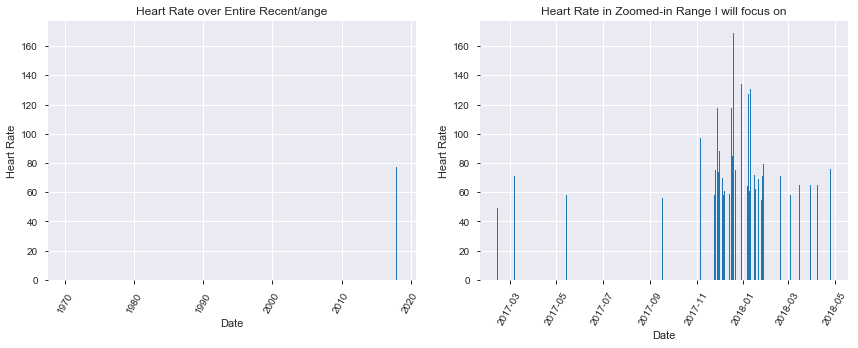

In [17]:
zoom_heartrate=heartrate['2017':]
plt.axes([0,0.05,0.85,0.9])
plt.bar(heartrate.index, heartrate['heart_rate'])
plt.xlabel('Date')
plt.title('Heart Rate over Entire Recent/ange')
plt.ylabel('Heart Rate')
plt.xticks(rotation=60)
plt.axes([1,0.05,0.85,0.9])
plt.bar(zoom_heartrate.index, zoom_heartrate['heart_rate'])
plt.xlabel('Date')
plt.title('Heart Rate in Zoomed-in Range I will focus on')
plt.ylabel('Heart Rate')
plt.xticks(rotation=60)
print('Count of Heart rates logged before 2016: ', heartrate['offset_createtime'][:'2016-01-01'].count())
print('Count of Heart rates logged 2016-2017: ', heartrate['offset_createtime']['2016-01-01':'2017-01-01'].count())
print('Count of Heart rates logged after 2017: ', heartrate['offset_createtime']['2017-01-01':].count())

## The individual climbs 2 floors (2 x 3 metres) regularly. Perhaps the individual works on the second floor of a building. 

## The individual climbs upto 12 floors (12 x 3 m = 36m) several times during the year. Perhaps the individual walks in a park with ~36m slopes. 

Floors climbed: 
Mean:  2.4195933456561924
Maximum:  12.0
Minimum:  1.0


(array([736695., 736726., 736754., 736785., 736815.]),
 <a list of 5 Text xticklabel objects>)

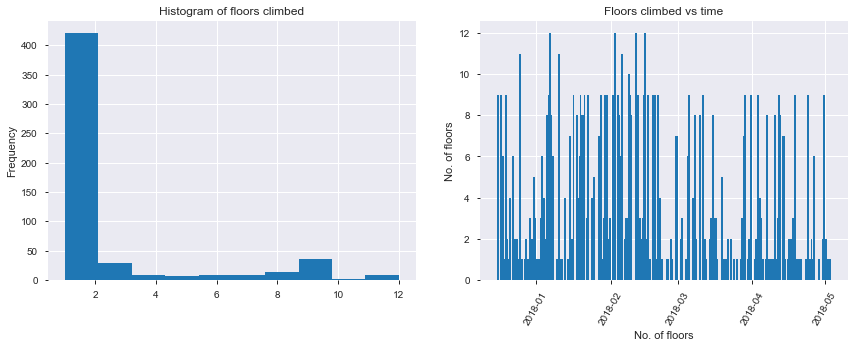

In [18]:
print('Floors climbed: ')
print('Mean: ', floors['floor'].mean())
print('Maximum: ', floors['floor'].max())
print('Minimum: ', floors['floor'].min())
plt.axes([0,0.05,0.85,0.9])
floors['floor'].plot(kind='hist')
plt.title('Histogram of floors climbed')
plt.axes([1,0.05,0.85,0.9])
plt.bar(floors.index, floors['floor'])
plt.xlabel('No. of floors')
plt.title('Floors climbed vs time')
plt.ylabel('No. of floors')
plt.xticks(rotation=60)

## No correlation was observed between Heart Rate and Floor Count data. 

Text(0.5, 1.0, 'Heart Rate vs Floor Count (no clear correlation)')

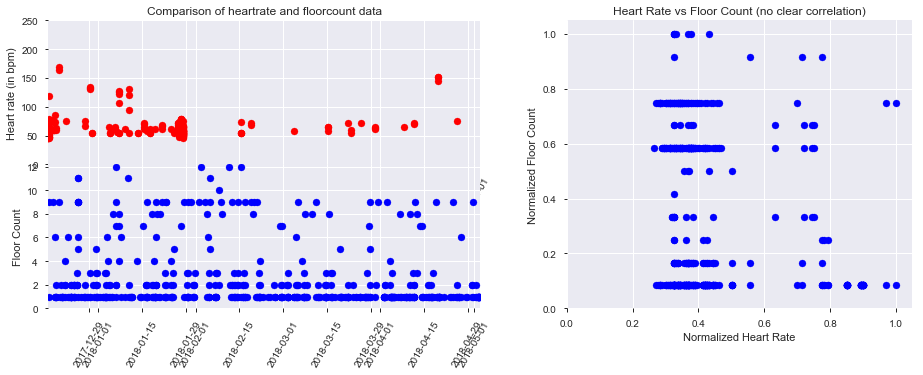

In [19]:
plt.axes([0,.5,1,0.5])
plt.scatter(heartrate.index,heartrate['heart_rate'], label='heart rate', color='red')
plt.xticks(rotation=60)
plt.ylabel('Heart rate (in bpm)')
plt.title('Comparison of heartrate and floorcount data')
plt.xlim('2017-12-16','2018-05-03')
plt.ylim(0,250)
plt.axes([0,0,1,0.5])
plt.scatter(floors.index,floors['floor'], label='floor count', color='blue')
plt.xlim('2017-12-16','2018-05-03')
plt.ylim(0,12.2)
plt.xticks(rotation=60)
plt.ylabel('Floor Count')

plt.axes([1.2,0,0.8,1])
merge=pd.merge(heartrate,floors, how='inner', left_on=heartrate.index.date, right_on=floors.index.date)
plt.scatter(merge['heart_rate']/169,merge['floor']/12, label='floor count', color='blue')
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.xlabel('Normalized Heart Rate')
plt.ylabel('Normalized Floor Count')
plt.title('Heart Rate vs Floor Count (no clear correlation)')

## Exercise

In [20]:
#Exercise data is available between 2016-06-25 and 2018-05-03. Majority of logs are after 2017-12-01 and the 2016 & some 2017
#timerange has been eliminated from analysis. 

In [21]:
print('Count of Heart rates logged before 2016: ', exercise['offset_createtime'][:'2016-01-01'].count())
print('Count of Heart rates logged 2016 to 2017: ', exercise['offset_createtime']['2016-01-01':'2017-01-01'].count())
print('Count of Heart rates logged 2017-01-10 to 2017-11-30: ', exercise['offset_createtime']['2017-01-10':'2017-11-30'].count())
print('Count of Heart rates logged after 2017-12-01: ', exercise['offset_createtime']['2017-12-01':].count())
exercise_sub=exercise['2017-12-01':]

Count of Heart rates logged before 2016:  0
Count of Heart rates logged 2016 to 2017:  4
Count of Heart rates logged 2017-01-10 to 2017-11-30:  3
Count of Heart rates logged after 2017-12-01:  334


In [22]:
walk=exercise_sub[exercise_sub['exercise_type']==1001] # dist calorie duration max mean speed 
run=exercise_sub[exercise_sub['exercise_type']==1002]
cycle=exercise_sub[exercise_sub['exercise_type']==11007]
elliptical=exercise_sub[exercise_sub['exercise_type']==15006]
swim=exercise_sub[exercise_sub['exercise_type']==14001] #calories, durarion
other=exercise_sub[exercise_sub['exercise_type']==0]

In [23]:
walk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-12-18 04:06:21.358000 to 2018-05-03 05:04:31
Data columns (total 26 columns):
Unnamed: 0           250 non-null int64
end_time             250 non-null object
altitude_loss        0 non-null float64
max_altitude         1 non-null float64
start_time           250 non-null object
count                3 non-null float64
altitude_gain        0 non-null float64
duration             250 non-null float64
max_heart_rate       165 non-null float64
mean_heart_rate      165 non-null float64
max_cadence          165 non-null float64
time_offset          250 non-null object
incline_distance     2 non-null float64
exercise_type        250 non-null int64
decline_distance     2 non-null float64
max_speed            247 non-null float64
calorie              250 non-null float64
mean_cadence         165 non-null float64
mean_speed           250 non-null float64
min_altitude         1 non-null float64
min_heart_rate       165 non-nul

In [24]:
type_exercise={1001:'Walking',1002:'Running',11007:'Cycling',13001:'Hiking',
               15006:'Elliptical',14001:'Swimming',0:'Other Activities'}
holder_list=[]
for value in exercise_sub['exercise_type']:
    value=type_exercise[value]
    holder_list.append(value)
exercise_sub['exercise_type']=holder_list

C:\Users\orpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## The majority of the individuals activity consists of walking. Individual has logged 'Other Activity' several times. Individual enjoys swimming too.  

In [25]:
print('Activity----------Frequency')
print(exercise_sub['exercise_type'].value_counts())

Activity----------Frequency
Walking             250
Other Activities     47
Swimming             30
Cycling               4
Running               2
Elliptical            1
Name: exercise_type, dtype: int64


## Individual (oddly) prefers to swim between 2am-7am). Individual swims between January-April 2017, on all days of the week except Mondays. 30mins is the most common swim duration. 

## Person also takes many walks, every day of the week, throughout the timerange. The majority of these walks are 15minutes long. A large number of walks too are pursued in the middle of the night, in addition to daytime walks. 

## Cycling, Elliptical exercise are pursued only in December 2017, right before the individual went on vacation (vacation inference is explained later in project). 

## Running is pursued only in December 2017 while the individual is on vacation in the UTC--0700 timezone (in addition to the marathon run training pursued in March-April 2018). 

## June-November, no exercise is logged. 


In [26]:
print('Cycling')
print('Elliptical')
print('Decline, max & mean speed, altitude, floors')

Cycling
Elliptical
Decline, max & mean speed, altitude, floors


(736664.0, 736829.0)

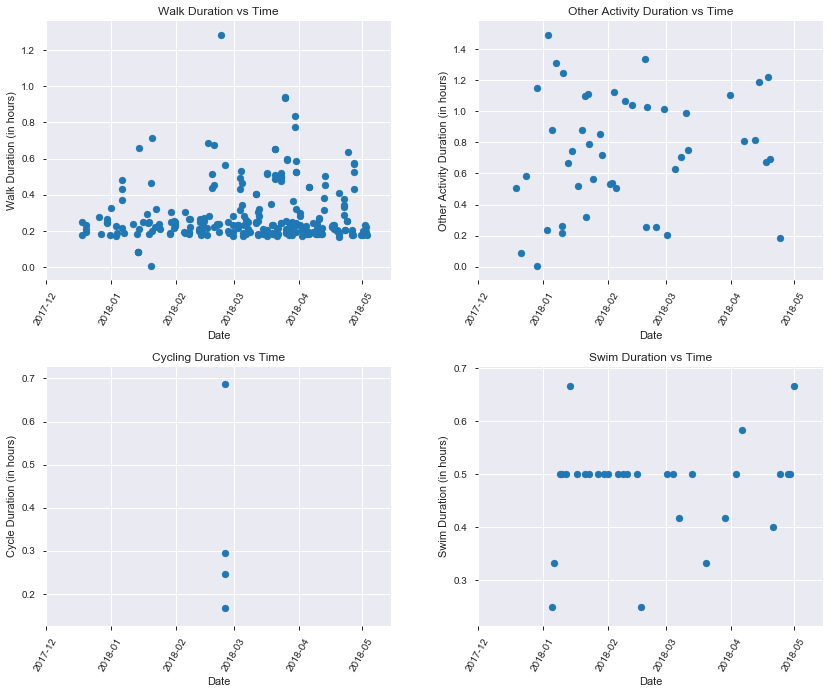

In [27]:
plt.axes([0,1.2,0.8,0.9])
plt.scatter(walk.index,walk['duration'])
plt.title('Walk Duration vs Time')
plt.xlabel('Date')
plt.ylabel('Walk Duration (in hours)')
plt.xticks(rotation=60)
plt.xlim('2017-12-01','2018-05-15')
plt.axes([1,0,0.8,0.9])
plt.scatter(swim.index,swim['duration'])
plt.title('Swim Duration vs Time')
plt.xlabel('Date')
plt.ylabel('Swim Duration (in hours)')
plt.xticks(rotation=60)
plt.xlim('2017-12-01','2018-05-15')
plt.axes([1,1.2,0.8,0.9])
plt.scatter(other.index,other['duration'])
plt.title('Other Activity Duration vs Time')
plt.xlabel('Date')
plt.ylabel('Other Activity Duration (in hours)')
plt.xticks(rotation=60)
plt.xlim('2017-12-01','2018-05-15')
plt.axes([0,0,0.8,0.9])
plt.scatter(cycle.index,cycle['duration'])
plt.title('Cycling Duration vs Time')
plt.xlabel('Date')
plt.ylabel('Cycle Duration (in hours)')
plt.xticks(rotation=60)
plt.xlim('2017-12-01','2018-05-15')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

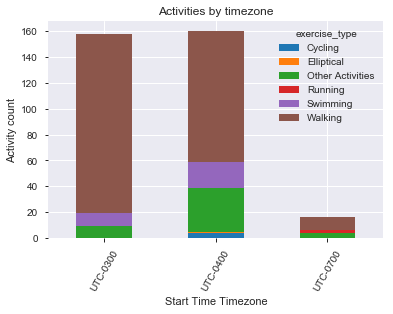

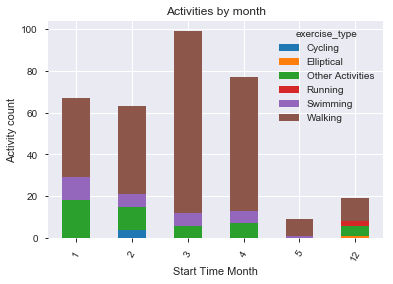

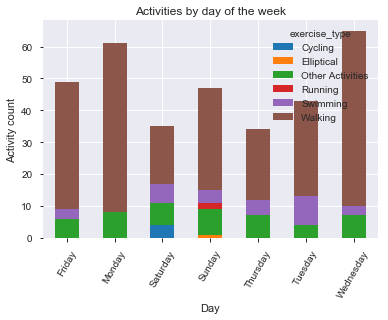

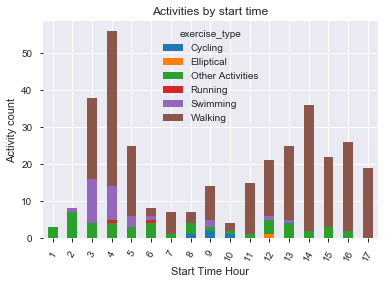

In [28]:
exercise_sub.groupby(['time_offset','exercise_type']).count()['Unnamed: 0'].unstack().plot(kind='bar', stacked=True)
plt.title('Activities by timezone')
plt.xlabel('Start Time Timezone')
plt.ylabel('Activity count')
plt.xticks(rotation=60)
exercise_sub.groupby([exercise_sub.index.month,'exercise_type']).count()['Unnamed: 0'].unstack().plot(kind='bar', stacked=True)
plt.title('Activities by month')
plt.xlabel('Start Time Month')
plt.ylabel('Activity count')
plt.xticks(rotation=60)
exercise_sub.groupby([exercise_sub.index.weekday_name,'exercise_type']).count()['Unnamed: 0'].unstack().plot(kind='bar', stacked=True)
plt.title('Activities by day of the week')
plt.xlabel('Day')
plt.ylabel('Activity count')
plt.xticks(rotation=60)
exercise_sub.groupby([exercise_sub.index.hour,'exercise_type']).count()['Unnamed: 0'].unstack().plot(kind='bar', stacked=True)
plt.title('Activities by start time')
plt.xlabel('Start Time Hour')
plt.ylabel('Activity count')
plt.xticks(rotation=60)

## Running is the most efficient calorie burning activity for this individual. Walking and 'Other activities' are the least efficient. Average calories burnt during swimming is equally matched by the average duration of time spent swimming. 

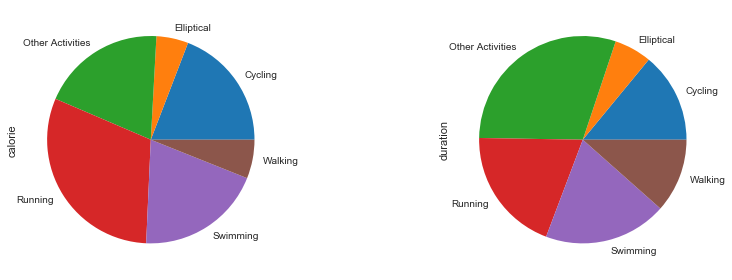

In [29]:
plt.axes([0,1,0.8,0.9])
exercise_sub.groupby(['exercise_type']).mean()['calorie'].plot(kind='pie')
plt.axes([1,1,0.8,0.9])
exercise_sub.groupby(['exercise_type']).mean()['duration'].plot(kind='pie')

## Sleep

## The individual possibly takes a vacation between 22 December 2017 and 1 January 2018 to a place in the GMT-7 timezone. The person resides in the GMT-4/GMT-3 timezone (daylight saving starts in March in this person's place of residence)

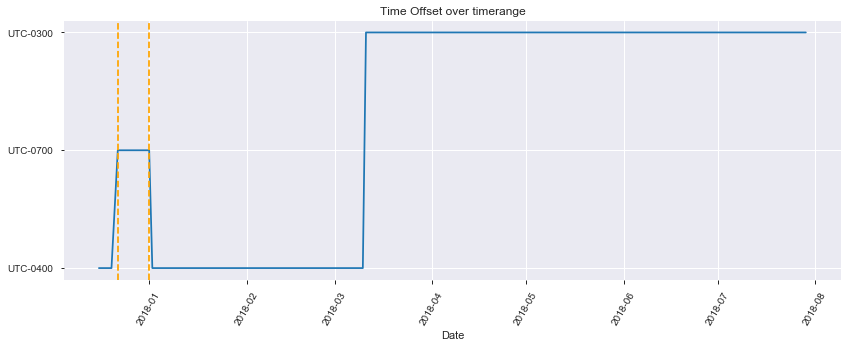

In [30]:
ax=plt.axes([0,0.05,1.8,0.9])
plt.plot(sleepdata.index.date, sleepdata['time_offset'])
plt.xlabel('Date')
plt.title('Time Offset over timerange')
plt.xticks(rotation=60)
plt.axvline(x='2017-12-22', linestyle='--', color='orange')
plt.axvline(x='2018-01-01', linestyle='--', color='orange')

## Individual goes to sleep most often at 11pm or 12am and sleeps for ~7 hours. If the person goes to bed earlier, at 9pm or 10pm, the person is able to spend more time in bed. If the person goes to bed at 8pm, the person wakes up in about 6 hours, perhaps to engage in early morning exercise activities. 

## The person takes several day-time naps. Perhaps to make up for sleep lost on the nights the individual swims or walks in the night. 

## When individual goes to bed between 1am - 6am, person manages to get 6-8h of sleep on average. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

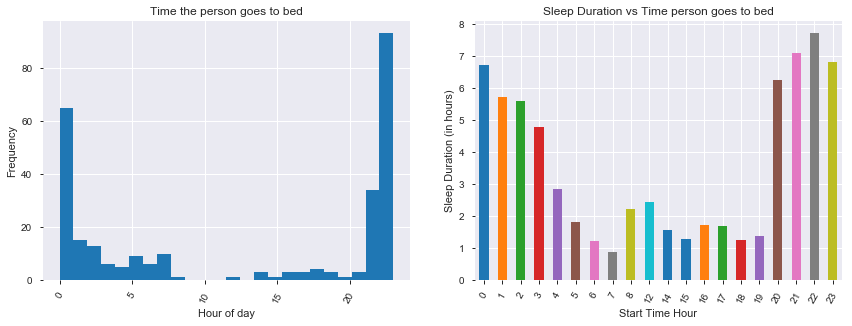

In [31]:
plt.axes([0,0.05,0.85,0.9])
sleepdata['offset_starttime'].dt.hour.plot(kind='hist', bins=24)
plt.xlabel('Hour of day')
plt.title('Time the person goes to bed')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.axes([1,0.05,0.85,0.9])
sleepdata.groupby(sleepdata.offset_starttime.dt.hour).mean()['duration'].plot(kind='bar')
plt.xlabel('Start Time Hour')
plt.title('Sleep Duration vs Time person goes to bed')
plt.ylabel('Sleep Duration (in hours)')
plt.xticks(rotation=60)

## The individual's sleep duration decreases on weekend nights. 

Text(2.0, 6.2, '')

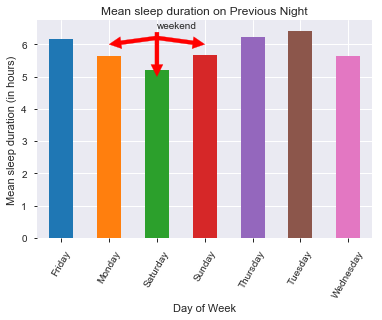

In [32]:
sleepdata.groupby(sleepdata.index.weekday_name)['duration'].mean().plot(kind='bar')
plt.xlabel('Day of Week')
plt.title('Mean sleep duration on Previous Night')
plt.ylabel('Mean sleep duration (in hours)')
plt.xticks(rotation=60)
plt.annotate('weekend', xy=(2.0, 5.0), xytext=(2.0, 6.5), arrowprops={'color':'red'})
plt.annotate('', xy=(1 , 6 ), xytext=(2.0, 6.2), arrowprops={'color':'red'})
plt.annotate('', xy=(3 , 6 ), xytext=(2.0, 6.2), arrowprops={'color':'red'})

In [33]:
day_sleep=sleepdata[sleepdata['offset_starttime'].dt.hour.isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19])]
night_sleep=sleepdata[sleepdata['offset_starttime'].dt.hour.isin([0,1,2,3,4,5,20,21,22,23])]
new=pd.merge(day_sleep, night_sleep, how='outer', left_on=day_sleep.index.date, right_on=night_sleep.index.date)
new['key_0']=pd.to_datetime(new['key_0'])
new.rename(columns={'duration_x':'Daytime sleep'}, inplace=True)
new.rename(columns={'duration_y':'Nighttime sleep'}, inplace=True)
new.set_index('key_0', inplace=True)

## The individual takes several daytime naps. Person takes these naps on all days of the week, all months of the year that data is logged, while at home and while on vacation. 

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

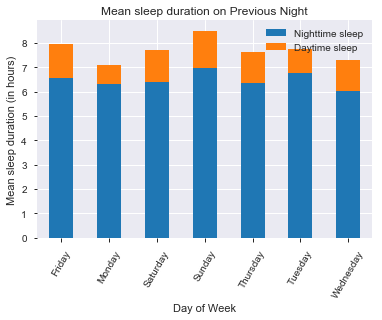

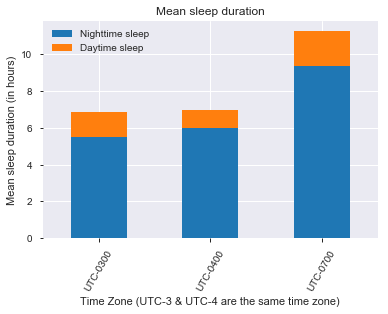

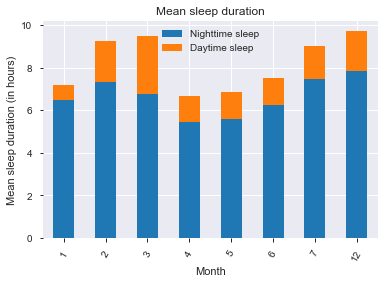

In [34]:
new.groupby(new.index.weekday_name).mean()[['Nighttime sleep','Daytime sleep']].plot(kind='bar', stacked=True)
plt.xlabel('Day of Week')
plt.title('Mean sleep duration on Previous Night')
plt.ylabel('Mean sleep duration (in hours)')
plt.xticks(rotation=60)
new.groupby('time_offset_x').mean()[['Nighttime sleep','Daytime sleep']].plot(kind='bar', stacked=True)
plt.xlabel('Time Zone (UTC-3 & UTC-4 are the same time zone)')
plt.title('Mean sleep duration')
plt.ylabel('Mean sleep duration (in hours)')
plt.xticks(rotation=60)
new.groupby(new.index.month).mean()[['Nighttime sleep','Daytime sleep']].plot(kind='bar', stacked=True)
plt.xlabel('Month')
plt.title('Mean sleep duration')
plt.ylabel('Mean sleep duration (in hours)')
plt.xticks(rotation=60)

## The individual lives in GMT-3/GMT-4 timezone.

## Literature says that women ages 40-49 have the highest average RHR of all users at 67.4 bpm, while men ages 40-49 have the highest average RHR among males at 64.6 bpm. Since this individual has a mean heart rate of 64.5 BPM this person may be a man between 40-49 years of age. 

## The individual performs limited physical activity. He logs 30 mins of swimming regularly between Jan-April 2017 but doesn't log any activity apart from walking till December. In December 2017 the individual seems to get back to exercise with renued enthusiasm. He tries cycling and using an elliptical machine. While of vacation he goes running. Perhaps this motivates him to train for a 10km marathon. Between Jan-April, 2018 he trains. His average running pace is 3.06m/s with a maximum speed of 6.94m/s reached in the training period. His marathon was likely on 27th April 2018. 

## The individual exercises at odd hours in 2017. He tends to swim and walk long distances in the middle of the night. As a result he also has to take a lot of daytime naps, he takes these naps throughout the year. But in 2018 he seems to get back in track with life and trains for the marathon either at 5am, 7am or at 3pm. He logs lower steps in the late morning and afternoon so this is probably when he goes to work. 

## In 2018 it is possible that the individual works (or visits often) a place that is on the 2nd floor of a building. It is possible that the individual's workplace is 15minutes away from his home and he chooses to walk there - because we observe serveral 15 minute walks throughout the exercise timerange. 